In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
wages = pd.read_csv('WAG_C_M.csv', sep=';', index_col='month')

In [3]:
wages.head()

,WAG_C_M
month,
01.01.1993,15.3
01.02.1993,19.1
01.03.1993,23.6
01.04.1993,30.6
01.05.1993,37.5


Text(0.5, 1.0, 'Nominal wage in Russia 1993-2014')

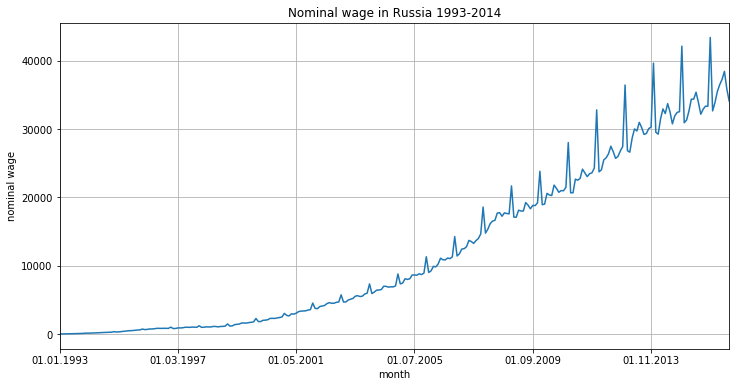

In [4]:
plt.figure(figsize=(12,6))
wages.WAG_C_M.plot()
plt.ylabel('nominal wage')
plt.grid()
plt.title('Nominal wage in Russia 1993-2014');

### Стационарность

Ряд нестационарен, т.к. имеет как тренд, так и сезонность.
Хоть это и очевидно, проверим нестационарность критерием Дики-Фулера:

In [5]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.WAG_C_M)[1])

Критерий Дики-Фуллера: p=0.991850


Ряд очень уверенно нестационарен. Сделаем его стационарным.
Наблюдаемая дисперсия растёт со временем. Начнём с преобразованием Бокса-Кокса.

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


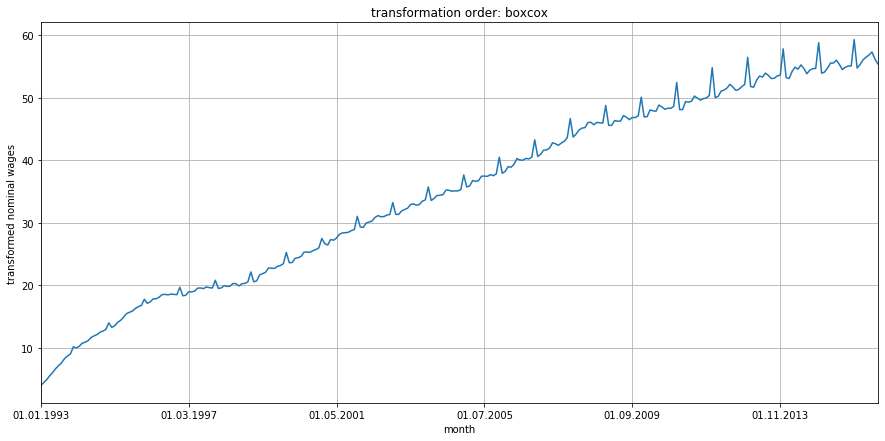

In [27]:
wages['wages_boxcox'], lmbda = stats.boxcox(wages.WAG_C_M)
plt.figure(figsize(15,7))
wages.wages_boxcox.plot()
plt.grid()
plt.ylabel('transformed nominal wages')
plt.title('transformation order: boxcox')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.wages_boxcox)[1])

Дисперсия поубавилась, но заметна. Тренд так и остался. Ряд по прежнему очень нестационарен.
Проведем сезонное дифференцирование.

Критерий Дики-Фуллера: p=0.014697


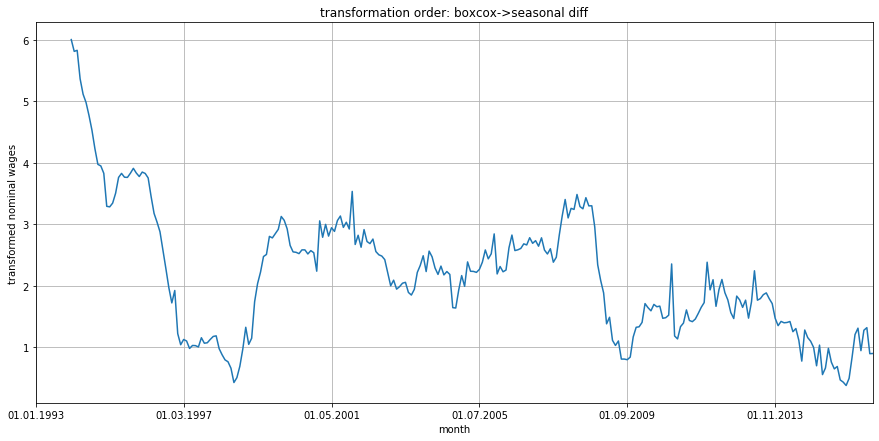

In [28]:
wages['wages_boxcox_d12'] = wages['wages_boxcox'] - wages['wages_boxcox'].shift(12)
plt.figure(figsize(15,7))
wages.wages_boxcox_d12.plot()
plt.ylabel('transformed nominal wages')
plt.title('transformation order: boxcox->seasonal diff')
plt.grid()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.wages_boxcox_d12.dropna())[1])

По критерию Дики-Фулера ряд уже достаточно стационарен.
Проведем его STL-декомпозицию

<Figure size 1080x720 with 0 Axes>

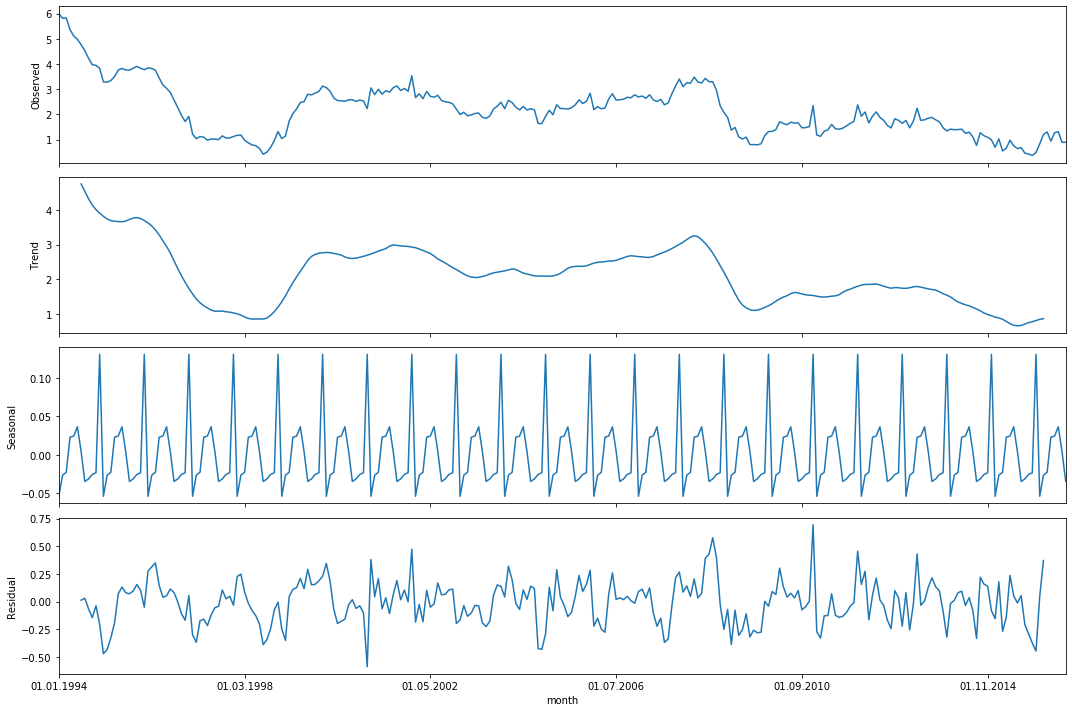

In [35]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages.wages_boxcox_d12.dropna(), freq=12).plot();

Остается трендовая составляющая. Продифференцируем ряд.

Критерий Дики-Фуллера: p=0.000000


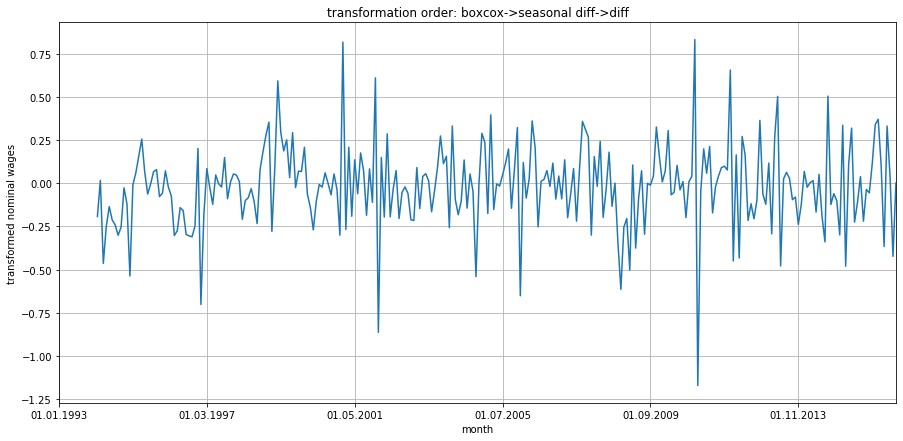

In [36]:
wages['wages_boxcox_d12_d1'] = wages['wages_boxcox_d12'] - wages['wages_boxcox_d12'].shift(1)
plt.figure(figsize(15,7))
wages.wages_boxcox_d12_d1.plot()
plt.ylabel('transformed nominal wages')
plt.title('transformation order: boxcox->seasonal diff->diff')
plt.grid()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.wages_boxcox_d12_d1.dropna())[1])

Очень уверенно стационарный ряд. Всё же посмотрим на STL-декомпозицию:

<Figure size 1080x720 with 0 Axes>

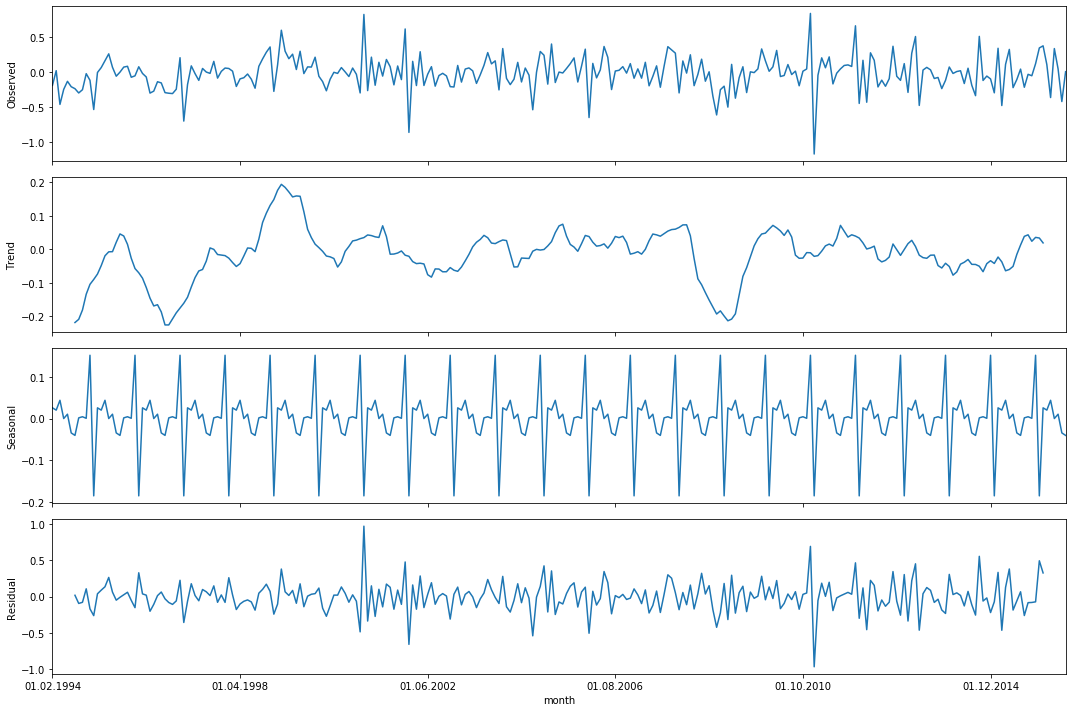

In [38]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages.wages_boxcox_d12_d1.dropna(), freq=12).plot();

Тренд колеблется недалеко от нуля. Сезонная составляющая тоже.

### Начальные приближения p, P, q, Q

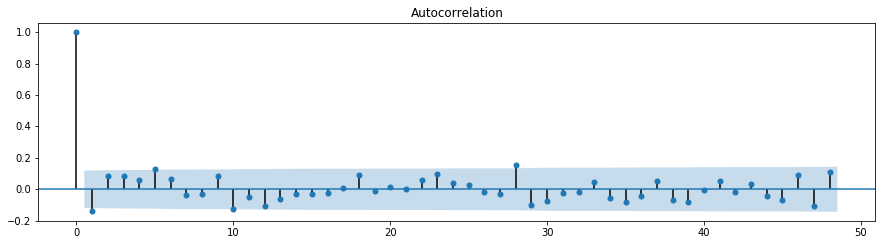

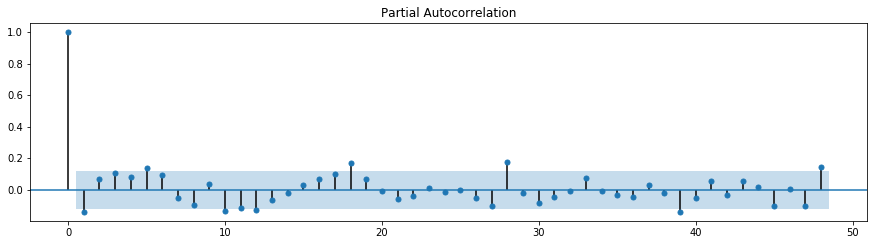

In [39]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wages.wages_boxcox_d12_d1.dropna().values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wages.wages_boxcox_d12_d1.dropna().values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=1, P=1, p=10

In [75]:
ps = range(5, 11)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

In [76]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wages.wages_boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 4min 6s, sys: 6.06 s, total: 4min 12s
Wall time: 1min 3s


In [77]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters       aic
10   (6, 0, 1, 0) -7.552970
11   (6, 0, 1, 1) -7.213253
46  (10, 1, 1, 0) -7.168053
45  (10, 1, 0, 1) -6.746419
9    (6, 0, 0, 1) -6.591533


In [78]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       wages_boxcox   No. Observations:                  284
Model:             SARIMAX(6, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  11.776
Date:                            Mon, 06 Apr 2020   AIC                             -7.553
Time:                                    21:31:00   BIC                             21.264
Sample:                                         0   HQIC                             4.017
                                            - 284                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1991      0.045     -4.401      0.000      -0.288      -0.110
ar.L2          0.0224      0.066   

### Остатки

Критерий Стьюдента: p=0.525618
Критерий Дики-Фуллера: p=0.000000


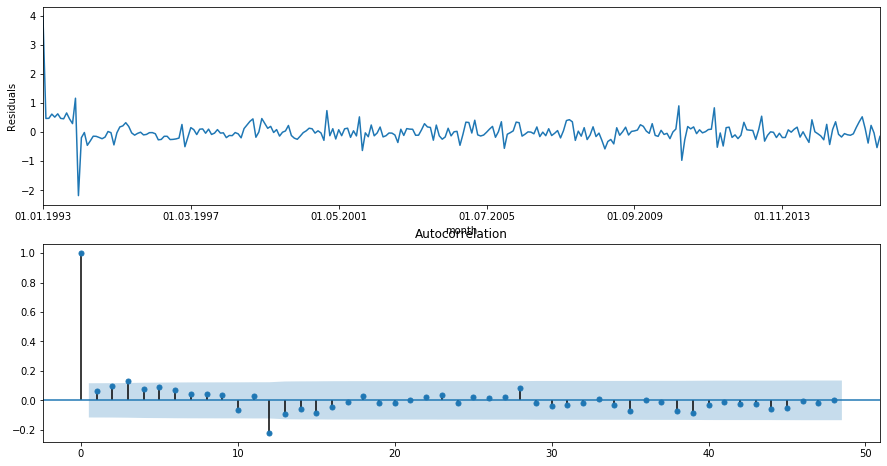

In [79]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.dropna().plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.dropna().values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid.dropna(), 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid.dropna())[1])

Остатки не смещены и стационарны.
По критерию Льюнга-Бокса остатки не автокоррелированы, однако на коррелограмме видна значимая автокорреляция с годовой сезонностью. Буду благодарен, если кто-то из проверяющих подскажет, можно ли с этим что-то поделать.

Построим модель

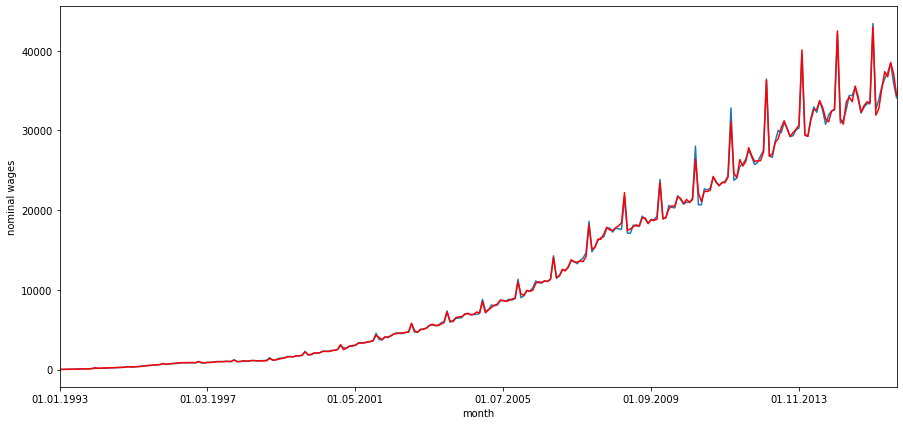

In [81]:
wages['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wages.WAG_C_M.plot()
wages.model.dropna().plot(color='r')
plt.ylabel('nominal wages')
pylab.show()

Модель достаточно точно описывает исходные данные.

### Прогноз

/home/bulat/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


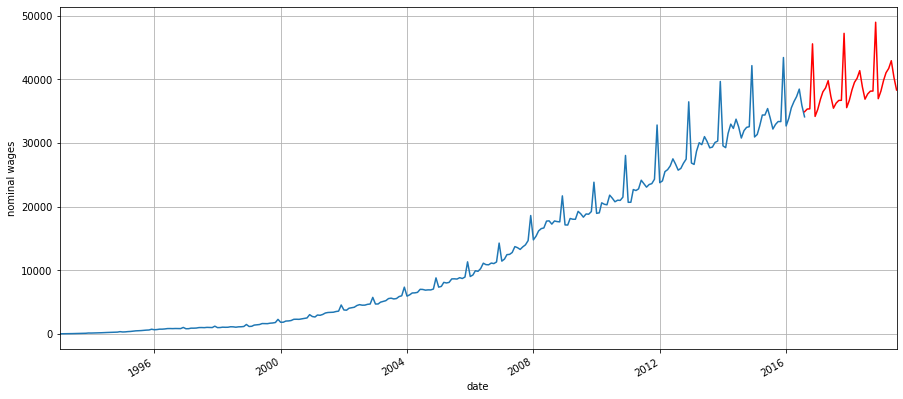

In [188]:
wages2 = wages[['WAG_C_M']]
wages2.index = pd.to_datetime(wages2.index, format='%d.%m.%Y')
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wages2.columns)
wages2 = pd.concat([wages2, future])
wages2['date'] = wages2.index
wages2.index = range(0,320)
wages2['forecast'] = invboxcox(best_model.forecast(steps=36), lmbda)
wages2.index = wages2.date

plt.figure(figsize(15,7))
wages2.WAG_C_M.plot()
wages2.forecast.plot(color='r')
plt.grid()
plt.ylabel('nominal wages')
pylab.show()